# Create streamplots from the LES data 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

try:
    import padeopsIO as pio
except:
    pass  # fix this later

%load_ext autoreload
%autoreload 2

In [209]:
cts = [-2.0, 1.0, 1.4, 1.5, 2.5, 4]
LES = []

for ct in cts:
    fname = "ct_{:.1f}".format(ct)
    case = pio.BudgetIO("../LES_data", filename=fname, npz=True)
    LES.append(case)

Define the plotting function here: 

In [236]:
# take 15
def plot(
    case,
    xlim=[-3, 3],
    symmetry=None,
    alpha_x=1.5,
    alpha_y=0.4,
    lw_max=2.0,
    lw_exp=0.6,
    bkgd_key="pbar",
    density=0.6,
    start_points=None,
    cmap="RdBu",
    fig_kwargs={},
    streamline_color="k",
    turbine_color="gray",
    plot_turbine=True,
):
    """
    Plotting function

    Arguments
    ---------
    case : padeopsIO.BudgetIO
        Object with PadeOps data
    xlim : list
        Limits on x for plotting
    symmetry : bool
        Forces symmetry into fields if True.
    alpha_x, alpha_y : float
        Gaussian taper for background field
    lw_max : float
        Maximum linewidth for streamlines
    bkgd_key : str
        Key for background contours.
    density : float
        Density keyword in plt.streamplot
    """
    sl = case.slice(
        budget_terms=["ubar", "vbar", bkgd_key], zlim=0, xlim=xlim, ylim=[-1.5, 1.5]
    )

    if symmetry is None:
        symmetry = False
        if case.turbineArray.turbines[0].yaw == 0:
            symmetry = True

    # flip if using symmetry
    if symmetry:
        for key in ["ubar"]:
            sl[key] = (sl[key] + sl[key][:, ::-1]) * 0.5
        for key in ["vbar"]:
            sl[key] = (sl[key] - sl[key][:, ::-1]) * 0.5

    vbar_base = 0.1 * np.mean(
        np.abs(sl["vbar"])
    )  # streamlines look nicer with some base velocity
    s = np.sqrt(sl["vbar"] ** 2 + vbar_base)  # + sl['ubar']**2)
    lw = (s**lw_exp).T
    lw = lw / np.max(lw) * lw_max
    xG, yG = np.meshgrid(sl["x"], sl["y"])
    ymask = (yG > 0).reshape(xG.shape)
    tmask = ~((np.abs(xG) < 0.05) * (np.abs(yG) < 0.55)).reshape(xG.shape)

    # use a weighting function to mask out background field to white
    weight = np.exp(-yG.T**2 / (2 * alpha_y**2) - xG.T**2 / (2 * alpha_x**2))
    weight /= np.max(weight)
    field = sl[bkgd_key] * weight

    fig, ax = plt.subplots(**fig_kwargs)

    # LAYER 0: base field + blurring
    cmax = np.max(abs(field))
    ax.imshow(
        field.T,
        origin="lower",
        extent=sl["extent"],
        cmap=cmap,
        interpolation="bicubic",
        clim=[-cmax, cmax],
        zorder=0,
    )

    # LAYER 1: Mask to white
    f_mask = np.exp(-yG.T**2 / (4 * alpha_y**2) - xG.T**2 / (4 * alpha_x**2))
    f_mask = 1 - f_mask / np.max(f_mask)
    ax.imshow(
        np.ones_like(field).T,
        origin="lower",
        extent=sl["extent"],
        cmap="binary_r",
        interpolation="bilinear",
        clim=[-1, 1],
        zorder=1,
        alpha=f_mask.T,
    )

    # LAYER 2: Plot turbine line
    if plot_turbine:
        yawr = np.deg2rad(case.turbineArray.turbines[0].yaw)
        ax.plot(
            [np.sin(yawr), -np.sin(yawr)],
            np.array([-0.5, 0.5]) * np.cos(yawr),
            color=turbine_color,
            lw=2,
            zorder=2,
            solid_capstyle="round",
        )

    # LAYER 3: Plot streamlines
    if start_points is None:
        start_points = get_start_points(case.turbineArray.turbines[0].ct, case=case)
    # plot y>0 streamlines
    u = np.ma.array(sl["ubar"].T, mask=~ymask & tmask)
    v = np.ma.array(sl["vbar"].T, mask=~ymask & tmask)
    if streamline_color is None:
        streamline_color = "k"  #  list(np.array([1,1,1]) * 0.35)  # Streamline color
    ret = ax.streamplot(
        xG,
        yG,
        u,
        v,
        color=streamline_color,
        arrowstyle="fancy",
        arrowsize=0.7,
        density=density,
        start_points=start_points,
        linewidth=lw,
        zorder=3,
    )
    ret.lines.set_capstyle(
        "round"
    )  # try to fix the disconnected line segments visually
    # plot y<0
    u = np.ma.array(
        sl["ubar"].T, mask=ymask & tmask
    )  # flip the mask, there's probably a function for this
    v = np.ma.array(sl["vbar"].T, mask=ymask & tmask)
    start_points[:, 1] *= -1
    ret = ax.streamplot(
        xG,
        yG,
        u,
        v,
        color=streamline_color,
        arrowstyle="fancy",
        arrowsize=0.7,
        density=density,
        start_points=start_points,
        linewidth=lw,
        zorder=3,
    )
    ret.lines.set_capstyle(
        "round"
    )  # try to fix the disconnected line segments visually
    # ax.scatter(start_points[:, 0], start_points[:, 1])  # debug starting points

    plt.axis("off")

    return fig, ax


def get_start_points(ct, N=3, R=0.5, xval=-2.0, case=None):
    if ct < -1:
        sp = np.ones((N, 2)) * 2  # start downstream
        sp[:, 1] = np.linspace(R / N, 2 * R, N)
    elif ct < 1.1:
        sp = np.ones((N, 2)) * -2  # start upstream
        sp[:, 1] = np.linspace(R / N, 2 * R, N)
    else:
        tmp = case.slice(budget_terms=["ubar"], zlim=0, ylim=0)
        xval = tmp["x"][np.argmin(tmp["ubar"])]

        mid = np.ceil(1.5 * N).astype(int)
        sp = np.ones((N + mid * 2, 2)) * -2  # start upstream
        sp[0:N, 1] = np.linspace(R / N, 2 * R, N)
        # additionally, seed points in the recirculation bubble
        sp[N : N + mid, 0] = xval
        sp[N : N + mid, 1] = np.linspace(R / (2 * N), R, mid)
        # finally, seed points in the wake
        sp[N + mid :, 0] = 2
        sp[N + mid :, 1] = np.linspace(R / (2 * N), 1.5 * R, mid)

    return sp

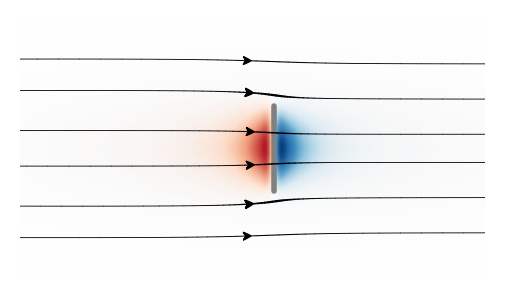

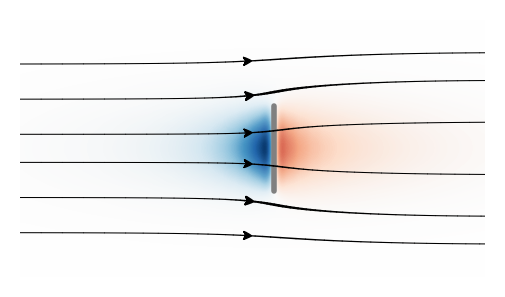

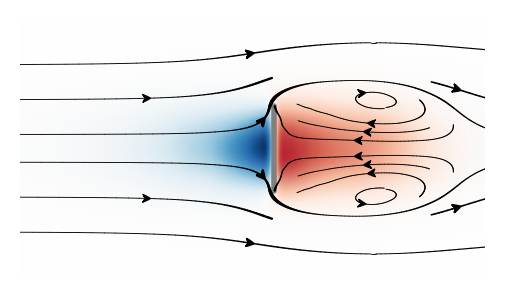

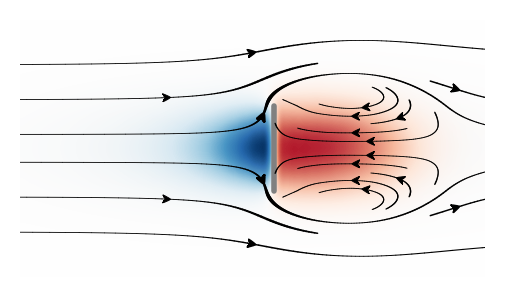

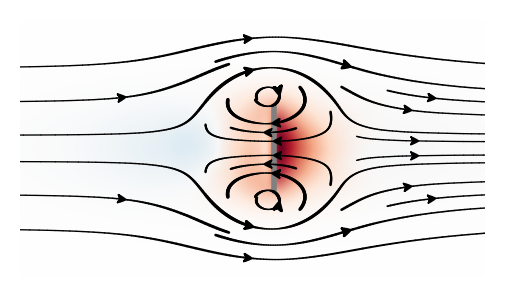

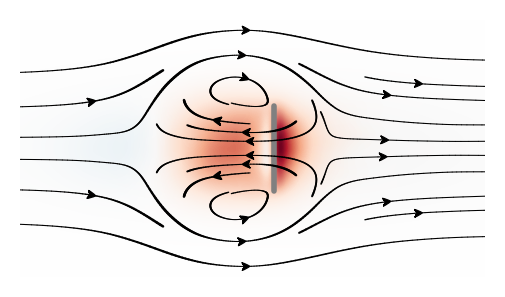

In [244]:
for case in LES:
    fig, ax = plot(
        case,
        lw_max=1.3,
        density=0.75,
        lw_exp=0.7,
        fig_kwargs={"figsize": (3, 2), "dpi": 200},
        xlim=[-3, 2.5],
    )
    plt.savefig("../figs/{:s}.png".format(case.filename), dpi=1200)
    plt.savefig("../figs/{:s}.eps".format(case.filename), dpi=1200)
    plt.savefig("../figs/{:s}.pdf".format(case.filename), dpi=1200)
    plt.show()
    # break